In [1]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
!pip install git+https://github.com/miykael/gif_your_nifti # nifti to gif 
import gif_your_nifti.core as gif2nif


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

  Cloning https://github.com/miykael/gif_your_nifti to /tmp/pip-req-build-1pw6k89o
  Running command git clone -q https://github.com/miykael/gif_your_nifti /tmp/pip-req-build-1pw6k89o
  Created wheel for gif-your-nifti: filename=gif_your_nifti-0.2.0-py3-none-any.whl size=6261 sha256=5cdfcdcd5e8c5562de0f29691e061c44a5eaee8d68aa4018bb62f4684f6c51a7
  Stored in directory: /tmp/pip-ephem-wheel-cache-uejbjnee/wheels/4a/8c/d1/b228c3b67231f7459e8f70d73f4dadaf65cd90692d41f43e88
Successfully built gif-your-nifti
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include

# Image data descriptions

All BraTS multimodal scans are available as  NIfTI files (.nii.gz) -> commonly used medical imaging format to store brain imagin data obtained using MRI and describe different MRI settings 
1. **T1**: T1-weighted, native image, sagittal or axial 2D acquisitions, with 1–6 mm slice thickness.
2. **T1c**: T1-weighted, contrast-enhanced (Gadolinium) image, with 3D acquisition and 1 mm isotropic voxel size for most patients.
3. **T2**: T2-weighted image, axial 2D acquisition, with 2–6 mm slice thickness.
4. **FLAIR**: T2-weighted FLAIR image, axial, coronal, or sagittal 2D acquisitions, 2–6 mm slice thickness.

Data were acquired with different clinical protocols and various scanners from multiple (n=19) institutions.

All the imaging datasets have been segmented manually, by one to four raters, following the same annotation protocol, and their annotations were approved by experienced neuro-radiologists. Annotations comprise the GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2), and the necrotic and non-enhancing tumor core (NCR/NET — label 1), as described both in the BraTS 2012-2013 TMI paper and in the latest BraTS summarizing paper. The provided data are distributed after their pre-processing, i.e., co-registered to the same anatomical template, interpolated to the same resolution (1 mm^3) and skull-stripped.



Text(0.5, 1.0, 'Mask')

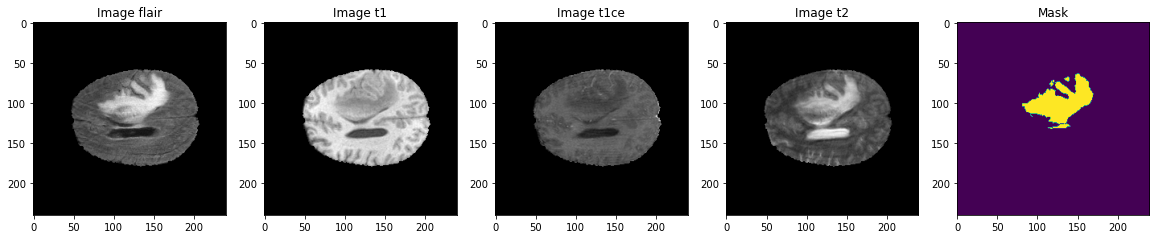

In [10]:
TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')


**Show whole nifti data -> print each slice from 3d data**

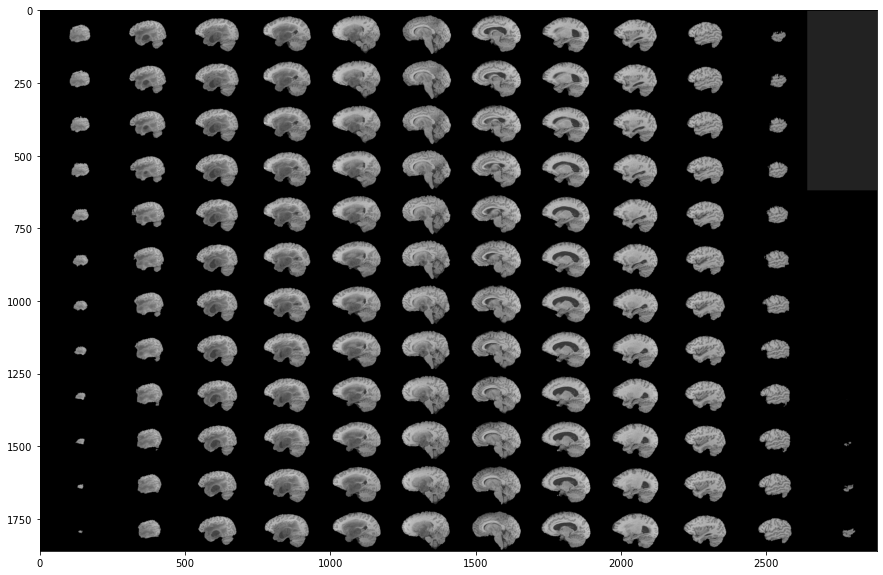

In [4]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

**Show segment of tumor for each above slice**

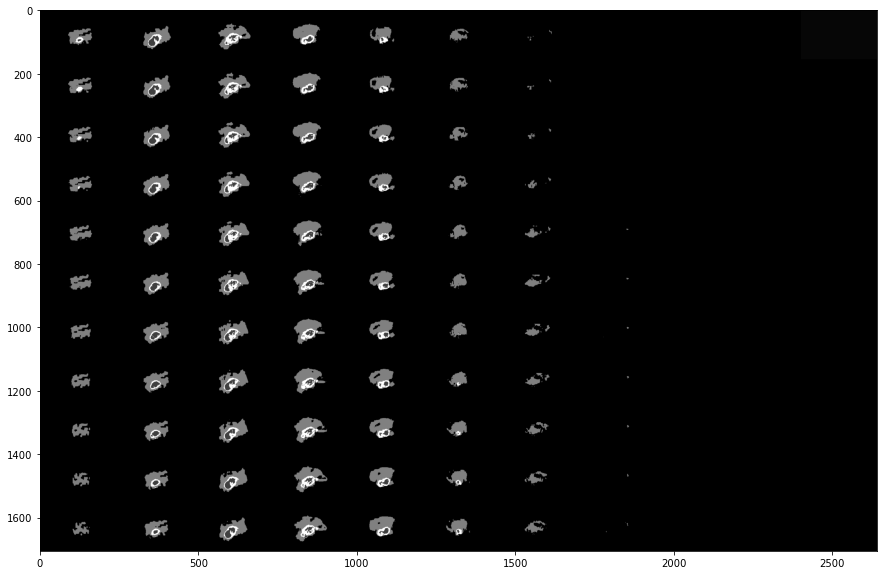

In [5]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

In [7]:
shutil.copy2(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii', './test_gif_BraTS20_Training_001_flair.nii')
gif2nif.write_gif_normal('./test_gif_BraTS20_Training_001_flair.nii')